In [ ]:
from PIL import Image
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR = '/content/drive/MyDrive/Face'

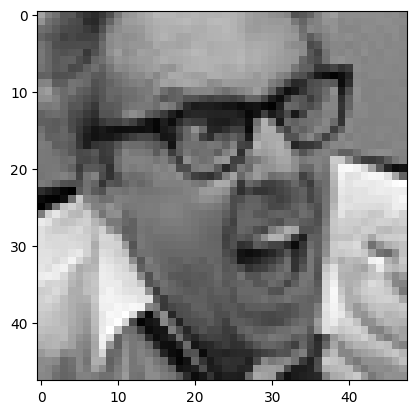

In [ ]:
def load_image_tensor(filepath):
    img = Image.open(filepath)
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(img)

    return img_tensor

img = load_image_tensor(f"{DATASET_DIR}/train/angry/Training_3908.jpg").reshape(48, 48)
plt.imshow(img,cmap="gray")

In [ ]:
Image_list = []
Label_list = []
label_dic = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprise":6,}
for folder in os.listdir(DATASET_DIR):
    for label in os.listdir(f"{DATASET_DIR}/"+folder):
        for image in os.listdir(f"{DATASET_DIR}/"+folder+"/"+label):
            Image_list.append(f"{DATASET_DIR}/"+folder+"/"+label+"/"+image)
            Label_list.append(label_dic[label])

Image_df = pd.DataFrame(Image_list,columns=["Image Path"])
Label_df = pd.DataFrame(Label_list,columns=["Label"])
Dataset_df = pd.concat([Image_df,Label_df],axis=1)

In [ ]:
from torch.utils.data import Dataset

class FERDataset(Dataset):
    def __init__(self, dataset_df):
        super().__init__()
        self.dataframe = dataset_df[:35880]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, i):
        return self.dataframe.iloc[i]

In [ ]:
import multiprocessing as mp
from torch.utils.data import DataLoader, random_split

def custom_collate_fn(batch):
    image_batch_tensor = torch.FloatTensor(len(batch), 48, 48)
    image_tensors = []
    labels = []
    for item in batch:
        image_tensor = load_image_tensor(item[0])
        image_tensors.append(image_tensor)
        labels.append(item[1])


    torch.cat(image_tensors, out=image_batch_tensor)
    label_batch_tensor = torch.LongTensor(labels)
    return (image_batch_tensor, label_batch_tensor)


def load_data(dataset_df, batch_sz=100, train_val_test_split=[0.3, 0.2, 0.5]):

    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"
    dataset = FERDataset(dataset_df)

    tr_va_te = []
    for frac in train_val_test_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va_te.append(actual_count)

    # split dataset into train, val and test
    train_split, val_split, test_split = random_split(dataset, tr_va_te)


    n_cpus = mp.cpu_count() # returns number of CPU cores on this machine
    train_dl = DataLoader(train_split,
                          batch_size=batch_sz,
                          shuffle=True,
                          collate_fn=custom_collate_fn,
                          num_workers=n_cpus)
    val_dl = DataLoader(val_split,
                        batch_size=batch_sz,
                        shuffle=True,
                        collate_fn=custom_collate_fn,
                        num_workers=n_cpus)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=n_cpus)
    return train_dl, val_dl, test_dl


Error: File not found at Face/train/angry/Training_3908.jpg


In [ ]:
train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=4)

In [ ]:
def image_grid(batch, ncols=4):
    height, width = batch[0].shape
    nrows = len(batch)//ncols # calculate the number of rows based on the number of columns needed by the user

    img_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

    return img_grid


def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"

    result = image_grid(batch, cols)
    fig = plt.figure(figsize=(4., 4.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result, cmap='gray')

In [ ]:
train_images, _ = next(iter(train_dl))
test_images, _ = next(iter(test_dl))

show_batch(train_images, title="Train images", cols=4)
show_batch(test_images, title="Test images", cols=4)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn
from torchsummary import summary


/content/Face/train/angry/Training_3908.jpg


In [ ]:
def train_model_gpu_lr(model, epochs, train_dl, optimiser, lr_scheduler, device):
    msg = ""
    for epoch in range(epochs):
        total_steps = len(train_dl)
        correct = 0
        total = 0
        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)

            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)

            optimiser.zero_grad()
            losses.backward()
            optimiser.step()

            preds = torch.argmax(output, dim=1)
            correct += int(torch.eq(preds, label_batch).sum())
            total += batch_sz
            minibatch_accuracy = 100 * correct / total


            if (batch_num + 1) % 5 == 0:
              print("\r " * len(msg), end='')
              msg = f'\rTrain epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
              print (msg, end='' if epoch < epochs else "\n",flush=True)

/content


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

def get_simple_conv_net():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),
        nn.Linear(16 * 14 * 14, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model = get_simple_conv_net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
            Linear-5                  [-1, 128]         401,536
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 403,242
Trainable params: 403,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.54
Estimated Total Size (MB): 1.78
----------------------------------------------------------------


In [ ]:
def train_model_gpu_lr_conv(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    for epoch in range(epochs):
        total_steps = len(train_dl)
        correct = 0
        total = 0

        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)

            optimiser.zero_grad()
            losses.backward()
            optimiser.step()

            preds = torch.argmax(output, dim=1)
            correct += int(torch.eq(preds, label_batch).sum())
            total += batch_sz
            minibatch_accuracy = 100 * correct / total


            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)

        lr_scheduler.step()

In [ ]:
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
network = get_simple_conv_net()
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(DEVICE)
train_model_gpu_lr_conv(network, epochs, train_dl, optim, lr_sch)


NameError: name 'load_data' is not defined

In [ ]:

DATA_PATH = "DATASET_DIR"

train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
network = get_simple_conv_net()
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(DEVICE)
train_model_gpu_lr_conv(network, epochs, train_dl, optim, lr_sch)


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inp):
        shortcut = self.shortcut(inp)
        inp = nn.ReLU()(self.bn1(self.conv1(inp)))
        inp = nn.ReLU()(self.bn2(self.conv2(inp)))
        inp = inp + shortcut  # The magic bit that cannot be done with nn.Sequential!
        return nn.ReLU()(inp)



class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.layer0_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0_bn   = nn.BatchNorm2d(64)
        self.layer0_relu = nn.ReLU()

        self.layer1_res1 = resblock(64, 64, downsample=False)
        self.layer1_res2 = resblock(64, 64, downsample=False)

        self.layer2_res1 = resblock(64, 128, downsample=True)
        self.layer2_res2 = resblock(128, 128, downsample=False)

        self.layer3_res1 = resblock(128, 256, downsample=True)
        self.layer3_res2 = resblock(256, 256, downsample=False)

        self.layer4_res1 = resblock(256, 512, downsample=True)
        self.layer4_res2 = resblock(512, 512, downsample=False)

        self.gap         = nn.AdaptiveAvgPool2d(1)
        self.flat        = nn.Flatten()
        self.fc          = nn.Linear(512, outputs)

    def forward(self, inp):
        inp = self.layer0_conv(inp)
        inp = self.layer0_pool(inp)
        inp = self.layer0_bn(inp)
        inp = self.layer0_relu(inp)

        inp = self.layer1_res1(inp)
        inp = self.layer1_res2(inp)

        inp = self.layer2_res1(inp)
        inp = self.layer2_res2(inp)

        inp = self.layer3_res1(inp)
        inp = self.layer3_res2(inp)

        inp = self.layer4_res1(inp)
        inp = self.layer4_res2(inp)

        inp = self.gap(inp)
        inp = self.flat(inp)
        inp = self.fc(inp)

        return inp


# convenience function
def get_resnet():
    return ResNet(1, ResBlock, outputs=10)


# Print model summary
summary(get_resnet(), input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
         MaxPool2d-2             [-1, 64, 7, 7]               0
       BatchNorm2d-3             [-1, 64, 7, 7]             128
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
       BatchNorm2d-6             [-1, 64, 7, 7]             128
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
          ResBlock-9             [-1, 64, 7, 7]               0
           Conv2d-10             [-1, 64, 7, 7]          36,928
      BatchNorm2d-11             [-1, 64, 7, 7]             128
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
         ResBlock-14             [-1, 6

In [ ]:
from PIL import Image
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
DATASET_DIR = 'data/images'

def load_image_tensor(filepath):
    img = Image.open(filepath)
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(img)

    return img_tensor

img = load_image_tensor(f"{DATASET_DIR}/train/angry/3905.jpg").reshape(48, 48)
plt.imshow(img,cmap="gray")

plt.imshow(img)
plt.axis('off')
plt.text(50, 50, "Angry", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.show()

Image_list = []
Label_list = []
label_dic = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprise":6,}
for folder in os.listdir(DATASET_DIR):
    for label in os.listdir(f"{DATASET_DIR}/"+folder):
        for image in os.listdir(f"{DATASET_DIR}/"+folder+"/"+label):
            Image_list.append(f"{DATASET_DIR}/"+folder+"/"+label+"/"+image)
            Label_list.append(label_dic[label])

Image_df = pd.DataFrame(Image_list,columns=["Image Path"])
Label_df = pd.DataFrame(Label_list,columns=["Label"])
Dataset_df = pd.concat([Image_df,Label_df],axis=1)

from torch.utils.data import Dataset

class FERDataset(Dataset):
    def __init__(self, dataset_df):
        super().__init__()
        # self.dataframe = dataset_df[:35880]
        self.dataframe = dataset_df

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, i):
        return self.dataframe.iloc[i]

import multiprocessing as mp
from torch.utils.data import DataLoader, random_split

def custom_collate_fn(batch):
    image_batch_tensor = torch.FloatTensor(len(batch), 48, 48)
    image_tensors = []
    labels = []
    for item in batch:
        image_tensor = load_image_tensor(item.iloc[0])
        image_tensors.append(image_tensor)
        labels.append(item.iloc[1])

    torch.cat(image_tensors, out=image_batch_tensor)
    label_batch_tensor = torch.LongTensor(labels)
    return (image_batch_tensor, label_batch_tensor)


def load_data(dataset_df, batch_sz=100, train_val_test_split=[0.3, 0.2, 0.5]):

    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"
    dataset = FERDataset(dataset_df)

    tr_va_te = []
    for frac in train_val_test_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va_te.append(actual_count)

    # split dataset into train, val and test
    train_split, val_split, test_split = random_split(dataset, tr_va_te)


    n_cpus = mp.cpu_count()
    train_dl = DataLoader(train_split,
                          batch_size=batch_sz,
                          shuffle=True,
                          collate_fn=custom_collate_fn,
                          num_workers=n_cpus)
    val_dl = DataLoader(val_split,
                        batch_size=batch_sz,
                        shuffle=True,
                        collate_fn=custom_collate_fn,
                        num_workers=n_cpus)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=n_cpus)
    return train_dl, val_dl, test_dl

def image_grid(batch, ncols=4):
    height, width = batch[0].shape
    nrows = len(batch)//ncols
    img_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

    return img_grid


def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"

    result = image_grid(batch, cols)
    fig = plt.figure(figsize=(4., 4.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result, cmap='gray')

train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=16)
train_images, _ = next(iter(train_dl))
test_images, _ = next(iter(test_dl))

show_batch(train_images, title="Train images", cols=4)
show_batch(test_images, title="Test images", cols=4)

import torch
import torch.nn as nn
from torchsummary import summary

def get_simple_conv_net():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),
        nn.Linear(16 * 24 * 24, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model = get_simple_conv_net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


summary(model, input_size=(1, 48, 48))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE



import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR

batch_sz = 16
learning_rate = 0.001
gamma = 0.8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 50


train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=4)

network = get_simple_conv_net()
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(DEVICE)
train_model_gpu_lr_conv(network, epochs, train_dl, optim, lr_sch)


import numpy as np

class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
       self.patience = patience
       self.tolerance = tolerance
       self.epoch_counter = 0
       self.max_validation_acc = np.NINF

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.epoch_counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True
        return False
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter


def train_model_final(model,
                      epochs,
                      dataloaders,
                      optimiser,
                      lr_scheduler,
                      writer,
                      early_stopper,
                      checkpoint_frequency):
    msg = ""
    for epoch in range(epochs):

        model.train()
        train_dl = dataloaders['train']

        total_steps_train = len(train_dl)
        correct_train = 0
        total_train = 0
        loss_train = 0

        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 48, 48)
            output = model(image_batch)
            loss_train = nn.CrossEntropyLoss()(output, label_batch)

            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()

            preds_train = torch.argmax(output, dim=1)
            correct_train += int(torch.eq(preds_train, label_batch).sum())
            total_train += batch_sz
            minibatch_accuracy_train = 100 * correct_train / total_train


            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_train}], Loss: {loss_train.item():.5f}, Acc: {minibatch_accuracy_train:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)

        print("")



USING ALL THSES CODES AND FUNCTIONS, WRITE A SIMPLE UNIT TEST CODE THAT WILL RUN

In [ ]:
"from torch import (
    load_data,
    get_simple_conv_net,
    train_model_gpu_lr_conv,
    EarlyStopper,
    train_model_final,
)

In [ ]:
# We do not need to define a new train function as the only changes have been to the internal
# structure of the model, not any of its inputs or outputs, so we can keep using
# the old one - very handy!

# loading data
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}


# Instantiate the res net
network = get_resnet()
# Send it to the GPU device
network = network.to(DEVICE)
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma)
# Call the lateset training function from last week
train_model_gpu_lr_conv_valid(network, epochs, dataloaders, optim, lr_sch)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
       self.patience = patience # How many epochs in a row the model is allowed to underperform
       self.tolerance = tolerance # How much leeway the model has (i.e. how close it can get to underperforming before it is counted as such)
       self.epoch_counter = 0 # Keeping track of how many epochs in a row were failed
       self.max_validation_acc = np.NINF # Keeping track of best metric so far

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.epoch_counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True
        return False

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import os


# Saves a model to file, and names it after the current epoch
def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(), save_path)

In [ ]:
def train_model_final(model,
                      epochs,
                      dataloaders,
                      optimiser,
                      lr_scheduler,
                      writer,
                      early_stopper,
                      checkpoint_frequency):
    msg = ""
    for epoch in range(epochs):
        #######################TRAINING STEP###################################
        model.train()  # set model to training mode
        train_dl = dataloaders['train'] # select train dataloader

        total_steps_train = len(train_dl)
        correct_train = 0
        total_train = 0
        loss_train = 0

        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)
            output = model(image_batch)
            loss_train = nn.CrossEntropyLoss()(output, label_batch)

            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()

            preds_train = torch.argmax(output, dim=1)
            correct_train += int(torch.eq(preds_train, label_batch).sum())
            total_train += batch_sz
            minibatch_accuracy_train = 100 * correct_train / total_train

            #### Fancy printing stuff, you can ignore this! ######
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_train}], Loss: {loss_train.item():.5f}, Acc: {minibatch_accuracy_train:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            #### Fancy printing stuff, you can ignore this! ######
        lr_scheduler.step()
        ########################################################################
        print("") # Create newline between progress bars
        #######################VALIDATION STEP##################################
        model.eval()  # set model to evaluation mode. This is very important, we do not want to update model weights in eval mode
        val_dl = dataloaders['val'] # select val dataloader

        total_steps_val = len(val_dl)
        correct_val = 0
        total_val = 0
        loss_val = 0

        for batch_num, (image_batch, label_batch) in enumerate(val_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)

            with torch.no_grad(): # no_grad disables gradient calculations, which are not needed when evaluating the model. This speeds up the calculations
                output = model(image_batch)
                loss_val = nn.CrossEntropyLoss()(output, label_batch)

                preds_val = torch.argmax(output, dim=1)
                correct_val += int(torch.eq(preds_val, label_batch).sum())
                total_val += batch_sz
                minibatch_accuracy_val = 100 * correct_val / total_val

                #### Fancy printing stuff, you can ignore this! ######
                if (batch_num + 1) % 5 == 0:
                    print(" " * len(msg), end='\r')
                    msg = f'Eval epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_val}], Loss: {loss_val.item():.5f}, Acc: {minibatch_accuracy_val:.5f}'
                    if early_stopper.epoch_counter > 0:
                        msg += f", Epochs without improvement: {early_stopper.epoch_counter}"
                    print (msg, end='\r' if epoch < epochs else "\n",flush=True)
                #### Fancy printing stuff, you can ignore this! ######
        ########################################################################
        print("")  # Create newline between progress bars

        # Log loss and accuracy metrics using the writer so we can see them in Tensorboard
        epoch_train_acc = 100 * correct_train / total_train
        epoch_val_acc = 100 * correct_val / total_val

        writer.add_scalar('Loss/train', loss_train, epoch)
        writer.add_scalar('Loss/val', loss_val, epoch)
        writer.add_scalar('Acc/train', epoch_train_acc, epoch)
        writer.add_scalar('Acc/val', epoch_val_acc, epoch)

        # Check whether we need to save the model to a checkpoint file
        if epoch % checkpoint_frequency == 0:
            save_checkpoint(model, epoch, "./saved_models")
        # Check whether we should stop the training based on the validation accuracy
        if early_stopper.should_stop(epoch_val_acc):
            print(f"\nValidation accuracy has not improved in {early_stopper.epoch_counter} epochs, stopping.")
            # if stopping, we also want to save the model's state
            save_checkpoint(model, epoch, "./saved_models")
            return

In [ ]:
# Putting it all together now, we can launch the final training run!
epochs =   15            # increase epochs to show off early stopper
batch_sz = 128           # increase batch size for faster processing
checkpoint_frequency = 3 # save model to a file every 3 epochs


# data loading with new batch size

dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

network = get_resnet()
optim = SGD(network.parameters(), lr=learning_rate)  # Stochastic gradient descent optimiser
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(DEVICE)

writer = SummaryWriter()
stopper = EarlyStopper(patience=3, tolerance=0) # stop training if model accuracy is not better than the max so far 3 times in a row
train_model_final(network, epochs, dataloaders, optim, lr_sch, writer, stopper, checkpoint_frequency)

NameError: name 'train_dl' is not defined

In [ ]:
last_epoch = 10
loaded_net_state_dict = torch.load(f"./saved_models/checkpoint_{last_epoch}.pth")
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

NameError: name 'torch' is not defined

In [ ]:
def test_model(model, dataloaders):
    model.eval()
    correct = 0
    total = 0

    test_dl = dataloaders['test']
    total_steps = len(test_dl)
    msg = ""
    for batch_num, (image_batch, label_batch) in enumerate(test_dl):
        batch_sz = len(image_batch)
        label_batch = label_batch.to(DEVICE)
        image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)
        out = model(image_batch)
        preds = torch.argmax(out, dim=1)
        correct += int(torch.eq(preds, label_batch).sum())
        total += label_batch.shape[0]
        if (batch_num + 1) % 5 == 0:
            print(" " * len(msg), end='\r')
            msg = f'Testing batch[{batch_num + 1}/{total_steps}]'
            print (msg, end='\r' if batch_num < total_steps else "\n", flush=True)
    print(f"\nFinal test accuracy for {total} examples: {100 * correct/total:.5f}")

In [ ]:
import pytorch_lightning as pl